# FEM para la ecuación de advección–difusión–reacción

En este notebook desarrollaremos la teoría de la formulación variacional y la implementación
del método de Elementos Finitos (FEM) con esquema θ para resolver la misma EDP en $\Omega=[0,1]^{2}$.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os

# En notebook __file__ no existe, usamos cwd → notebooks/
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
RESULTS_DIR = os.path.join(BASE_DIR, 'results')
os.makedirs(RESULTS_DIR, exist_ok=True)

# Ajustamos path para importar nuestro src
import sys

# Añadimos la carpeta raíz al path para poder importar src/fem.py
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path:
    sys.path.insert(0, root)

from src.fem import solve_fem, animate_fem


## 2. Formulación variacional

Partimos de la EDP no estacionaria:

\begin{equation*}
\frac{\partial u}{\partial t}
+ \mathbf{V}(x,y,t)\cdot\nabla u
- D\,\Delta u
+ k\,u
= f(x,y,t),
\quad
(x,y)\in \Omega=[0,L_x]\times[0,L_y],\; t>0,
\end{equation*}

con $u=0$ en $\partial\Omega$ (Dirichlet homogéneo) y condición inicial $u(x,y,0)=u_0(x,y)$.

---

### Paso 1: Forma débil en espacio

1. Multiplicamos por una función de prueba $v\in H_0^1(\Omega)$ y hacemos

   \begin{equation*}
   \int_\Omega \frac{\partial u}{\partial t}\,v\,dx
   + \int_\Omega (\mathbf{V}\cdot\nabla u)\,v\,dx
   + D\int_\Omega \nabla u\cdot\nabla v\,dx
   + k\int_\Omega u\,v\,dx
   = \int_\Omega f\,v\,dx.
   \end{equation*}

2. La segunda integral (advección) no requiere integración por partes en este caso.
3. En la tercera (difusión) integramos por partes:

   \begin{equation*}
   -D\int_\Omega \Delta u\,v\,dx
   = D\int_\Omega \nabla u\cdot\nabla v\,dx
     - D\int_{\partial\Omega} \frac{\partial u}{\partial n}v\,ds,
   \end{equation*}

   pero $v=0$ en $\partial\Omega$, así el término de borde desaparece.

---

### Paso 2: Discretización en espacio 

- Tomamos una base de elementos P1 (triángulos lineales) $\{\varphi_i\}_{i=1}^N$.  
- Aproximamos $u(x,t)\approx \sum_{j=1}^N U_j(t)\,\varphi_j(x)$ y $v=\varphi_i$.  
- Definimos las **formas bilineales**:

  \begin{equation*}
    m(u,v) = \int_\Omega u\,v\,dx,\quad
    a(u,v) = D\int_\Omega\nabla u\cdot\nabla v\,dx,\quad
    r(u,v) = k\int_\Omega u\,v\,dx,\quad
    c(u,v;t) = \int_\Omega (\mathbf{V}(t)\cdot\nabla u)\,v\,dx.
  \end{equation*}

- Al ensamblar, obtenemos las matrices:

  \begin{equation*}
    M_{ij} = m(\varphi_j,\varphi_i),\quad
    K_{ij} = a(\varphi_j,\varphi_i),\quad
    R_{ij} = r(\varphi_j,\varphi_i),\quad
    C_{ij}(t) = c(\varphi_j,\varphi_i;t).
  \end{equation*}

---

### Paso 3: Discretización en el tiempo (θ–method)

Tras el reúso de matrices espaciales, avanzamos de $t^n$ a $t^{n+1}=t^n+\Delta t$ con:

\begin{equation*}
\bigl(M + \theta\,\Delta t\,(K + C^{n+1})\bigr)\,U^{n+1}
= \bigl(M - (1-\theta)\,\Delta t\,(K + C^n)\bigr)\,U^n
+ \Delta t\bigl((1-\theta)F^n + \theta F^{n+1}\bigr),
\end{equation*}

donde $F^n$ es el vector de carga $\int f^n\,\varphi_i\,dx$.

---

Con esta base teórica clara, a continuación montaremos el código que implementa cada paso.  


## 3. Mallado y ensamblaje de matrices espaciales

En esta sección construimos:
1. La malla triangular uniforme en $[0,L_x]\times[0,L_y]$.
2. Las **formas bilineales** de masa, rigidez y reacción.
3. Las matrices globales $M$, $K$ y $R$ a partir de esas formas.


In [11]:
from skfem import MeshTri, ElementTriP1, Basis, asm
from skfem.assembly import BilinearForm
from skfem.helpers import grad, dot

# Parámetros de simulación
Tfin = 0.1      # tiempo final
D    = 0.5      # coeficiente de difusión
k    = 0.5      # coeficiente de reacción

# Parámetros de malla
nx, ny = 16, 16
Lx, Ly = 1.0, 1.0
x = np.linspace(0.0, Lx, nx)
y = np.linspace(0.0, Ly, ny)

# Mallado triangular tensorial
mesh = MeshTri.init_tensor(x, y)
basis = Basis(mesh, ElementTriP1())

print(f"Nodos: {mesh.p.shape[1]}, Triángulos: {mesh.t.shape[1]}")

# Definición de formas bilineales
@BilinearForm
def masa(u, v, w):
    return u * v

@BilinearForm
def rigidez(u, v, w):
    return dot(grad(u), grad(v))

@BilinearForm
def reaccion(u, v, w):
    return k * u * v

# Ensamblaje de las matrices globales
M = asm(masa,   basis)       # matriz de masa
K = D * asm(rigidez, basis)  # matriz de rigidez escalada por D
R = asm(reaccion, basis)     # matriz de reacción

print(f"M.shape = {M.shape}, K.shape = {K.shape}, R.shape = {R.shape}")


Nodos: 256, Triángulos: 450
M.shape = (256, 256), K.shape = (256, 256), R.shape = (256, 256)


## 4. Formas dependientes del tiempo

En la formulación variacional aparecen dos términos que varían con $t$:

1. **Advección**: $\displaystyle c(u,v;t) = \int_\Omega (\mathbf{V}(t)\cdot\nabla u)\,v\,dx$.  
2. **Carga**: $\displaystyle \int_\Omega f(x,y,t)\,v\,dx$.

Definiremos funciones que, dado un instante $t$, ensamblen las matrices/vectores asociados.


In [12]:
from skfem.assembly import BilinearForm, LinearForm
from skfem.helpers import grad, dot

def ensamblar_adveccion(t):
    """
    Ensambla la matriz de advección C(t) con 
    Vx = 1 + 0.5*sin(2π t/Tfin)*x, Vy = 0.5 + 0.25*cos(2π t/Tfin)*y.
    """
    @BilinearForm
    def adveccion(u, v, w):
        xq, yq = w.x
        Vx = 1.0 + 0.5 * np.sin(2*np.pi * t/Tfin) * xq
        Vy = 0.5 + 0.25 * np.cos(2*np.pi * t/Tfin) * yq
        return (Vx * grad(u)[0] + Vy * grad(u)[1]) * v
    return asm(adveccion, basis)

def ensamblar_carga(t):
    """
    Ensambla el vector fuente F(t) = ∫ (1+t)*sin(πx)sin(πy) v dx.
    """
    @LinearForm
    def carga(v, w):
        xq, yq = w.x
        return (1 + t) * np.sin(np.pi * xq) * np.sin(np.pi * yq) * v
    return asm(carga, basis)

# Prueba rápida en t=0
C0 = ensamblar_adveccion(0.0)
F0 = ensamblar_carga(0.0)
print(f"C0 shape: {C0.shape}, F0 length: {F0.shape}")


C0 shape: (256, 256), F0 length: (256,)


## 5. Condiciones de contorno e inicial

Antes de avanzar en el tiempo, imponemos:

1. **Dirichlet homogéneo** $(u=0)$ en el contorno $\partial\Omega$.  
2. **Condición inicial** como pulso gaussiano centrado.

También definimos el número de pasos temporales `nt` y el tamaño de paso `dt`.


In [13]:
# Parámetros temporales
dt = 0.01
nt = int(np.ceil(Tfin / dt))

# Nº grados de libertad
N = M.shape[0]

# Coordenadas de los nodos
X, Y = mesh.p

# Índices de contorno (Dirichlet u=0)
dofs_bdy = np.where(
    (X == 0.0) | (X == Lx) | (Y == 0.0) | (Y == Ly)
)[0]
all_dofs  = np.arange(N)
dofs_free = np.setdiff1d(all_dofs, dofs_bdy)

# Función de condición inicial
def cond_inic_xy(x, y):
    return np.exp(-50 * ((x - Lx/2)**2 + (y - Ly/2)**2))

# Construimos el vector inicial y aplicamos BC
u0 = cond_inic_xy(X, Y)
u0[dofs_bdy] = 0.0

# Preparamos almacenamiento de la solución
U = np.zeros((nt+1, N))
U[0] = u0.copy()

print(f"dt = {dt:.4f}, nt = {nt}")
print(f"dofs_bdy = {len(dofs_bdy)}, dofs_free = {len(dofs_free)}")
print(f"U.shape = {U.shape}")


dt = 0.0100, nt = 10
dofs_bdy = 60, dofs_free = 196
U.shape = (11, 256)


## 6. Bucle temporal (θ–method)

Avanzamos de $t^n$ a $t^{n+1}$ usando el esquema general:

\begin{equation*}
\bigl(M + \theta\,\Delta t\,(K + C^{n+1})\bigr)\,U^{n+1}
= \bigl(M - (1-\theta)\,\Delta t\,(K + C^n)\bigr)\,U^n
+ \Delta t\bigl((1-\theta)F^n + \theta F^{n+1}\bigr).
\end{equation*}


- **θ = 0**: Euler explícito  
- **θ = 1/2**: Crank–Nicolson  
- **θ = 1**: Euler implícito  

En cada paso:
1. Ensamblamos $C^n$ y $C^{n+1}$, así como $F^n$ y $F^{n+1}$.  
2. Formamos las matrices `lhs` y `rhs` y resolvemos solo sobre los dofs libres.  
3. Reconstruimos el vector completo y lo guardamos en `U`.


In [14]:
from scipy.sparse.linalg import spsolve

theta = 0.5   # Crank–Nicolson
dt = 0.01

# Bucle temporal
for n in range(nt):
    t_n   = n * dt
    t_np1 = (n+1) * dt

    # Ensamble en t^n y t^{n+1}
    Cn   = ensamblar_adveccion(t_n) + R
    Cnp1 = ensamblar_adveccion(t_np1) + R
    Fn   = ensamblar_carga(t_n)
    Fnp1 = ensamblar_carga(t_np1)

    # Construcción de lhs y rhs
    lhs = M + theta * dt * (K + Cnp1)
    rhs = M - (1 - theta) * dt * (K + Cn)

    # Restringir a nodos libres
    lhs_f = lhs[dofs_free][:, dofs_free]
    b = rhs.dot(U[n]) + dt * ((1 - theta) * Fn + theta * Fnp1)
    b_free = b[dofs_free]

    # Resolver y reconstruir
    u_free = spsolve(lhs_f, b_free)
    u      = np.zeros(N)
    u[dofs_free] = u_free

    # Guardar la solución del paso n+1
    U[n+1] = u.copy()

# Comprobación rápida
print("Bucle temporal completado. U.shape =", U.shape)


Bucle temporal completado. U.shape = (11, 256)


## 7. Evolución de la solución FEM en distintos tiempos

Mostramos la solución en 4 instantes equiespaciados para apreciar la disipación, usando la misma escala de color global.


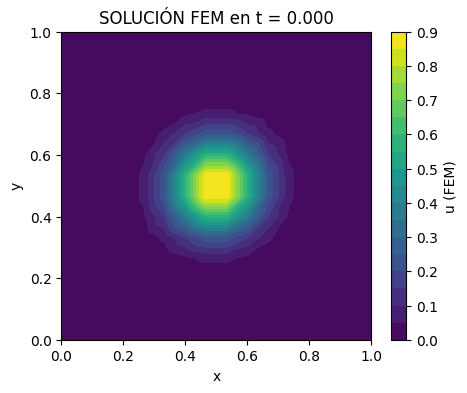

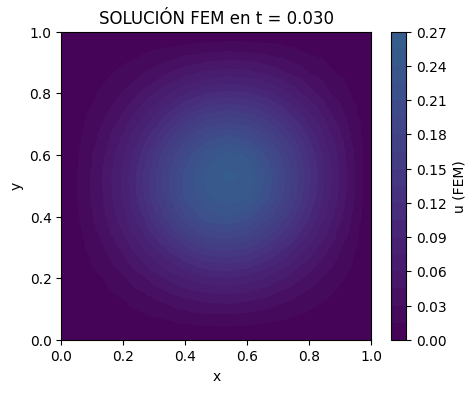

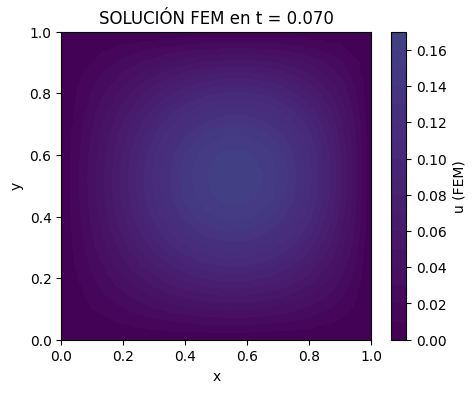

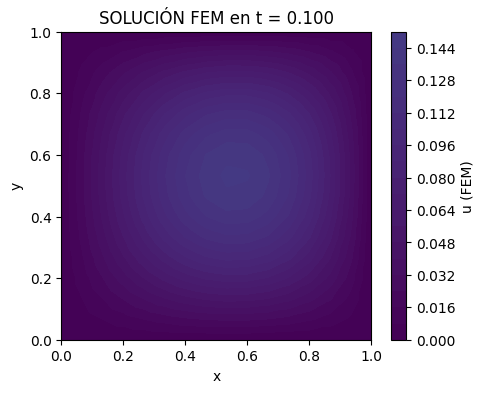

In [16]:
# Parámetros de ejemplo (mismos que antes)
nx, ny = 16, 16
Lx, Ly = 1.0, 1.0
Tfin    = 0.1
D, k    = 0.5, 0.5
theta   = 0.5
dt      = 0.01

# --- 1) Ejecutar solver FEM ---
U_fem, X_fem, Y_fem, mesh, dt_fem = solve_fem(
    nx, ny, Lx, Ly, Tfin, D, k, theta, dt
)

# --- 2) Evolución en 4 tiempos distintos ---
ntot = U_fem.shape[0]
indices = [0, ntot//3, 2*ntot//3, ntot-1]
vmin, vmax = U_fem.min(), U_fem.max()

for idx in indices:
    t = idx * dt_fem
    plt.figure(figsize=(5,4))
    plt.tricontourf(
        X_fem, Y_fem, mesh.t.T, U_fem[idx],
        levels=20, vmin=vmin, vmax=vmax
    )
    plt.colorbar(label='u (FEM)')
    plt.title(f"SOLUCIÓN FEM en t = {t:.3f}")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
